In [1]:
import os, os.path
import numpy
from astropy.io import ascii
%pylab inline
import matplotlib as mpl
mpl.style.use('classic')
from matplotlib.ticker import NullFormatter
from galpy.util import bovy_plot
import seaborn as sns
numpy.random.seed(4)

Populating the interactive namespace from numpy and matplotlib


## The data

### The gas data

#### $\mathbf{H_2}$

[McKee et al. (2015)](http://adsabs.harvard.edu/abs/2015ApJ...814...13M) take their spatial distribution from [Dame et al. (1987)](http://adsabs.harvard.edu/abs/1987ApJ...322..706D). Dame et al. estimate the FWHM of the distribution of molecular clouds and then assume the distribution is Gaussian, this gives them a Gaussian with a dispersion of 74 pc, or as McKee et al. state it: $\rho(z) \propto \exp(-[z/105\,\mathrm{pc}]^2)$.

We can check this using the recent molecular cloud catalog of [Miville-Deschênes et al. (2017)](http://adsabs.harvard.edu/abs/2017ApJ...834...57M). Let's download this catalog and plot the vertical distribution of all clouds at $8.25\,\mathrm{kpc} < R < 8.75\,\mathrm{kpc}$ (they seem to assume $R_0 = 8.5\,\mathrm{kpc}$:

In [2]:
cloud_name= 'apjaa4dfdt1_mrt.txt'
if not os.path.exists(cloud_name):
    !wget http://iopscience.iop.org/0004-637X/834/1/57/suppdata/apjaa4dfdt1_mrt.txt
cloud_data= ascii.read(cloud_name,format='cds')
# Compute distsance and height z based on whether near of far kinematic distance is more likely
d_cloud= cloud_data['Dn']
d_cloud[cloud_data['INF'] == 1]= cloud_data['Df'][cloud_data['INF'] == 1]
z_cloud= cloud_data['zn']
z_cloud[cloud_data['INF'] == 1]= cloud_data['zf'][cloud_data['INF'] == 1]

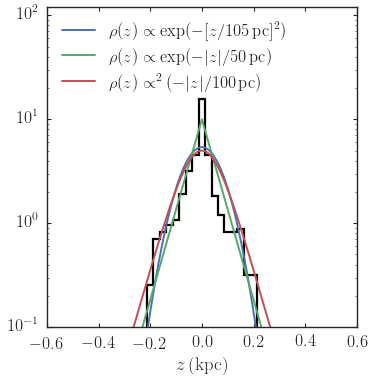

In [3]:
figsize(7,6)
bovy_plot.bovy_print(axes_labelsize=17.,text_fontsize=12.,xtick_labelsize=15.,ytick_labelsize=15.)
zbins_h2= numpy.arange(-0.2125,0.225,0.025)
zbinsp_h2= 0.5*(numpy.roll(zbins_h2,-1)+zbins_h2)[:-1]
d,e,_= hist(z_cloud[(cloud_data['Rgal'] > 8.25)*(cloud_data['Rgal'] < 8.75)],
            bins=zbins_h2,range=[-.5,.5],normed=True,histtype='step',lw=2.,color='k')
gca().set_yscale('log')
xs= numpy.linspace(-0.5,0.5,1001)
plot(xs,1./numpy.sqrt(2.*numpy.pi)/.074*numpy.exp(-0.5*xs**2./.074**2.),
     label=r'$\rho(z) \propto \exp(-[z/105\,\mathrm{pc}]^2)$')
plot(xs,1./0.1*numpy.exp(-numpy.fabs(xs)/.05),
    label=r'$\rho(z) \propto \exp(-|z|/50\,\mathrm{pc})$')
plot(xs,1./0.2*1./numpy.cosh(-xs/.1)**2.,
    label=r'$\rho(z) \propto \sech^2(-|z|/100\,\mathrm{pc})$')
legend(loc='upper left',frameon=False,fontsize=15.)
ylim(0.1,120.)
xlabel(r'$z\,(\mathrm{kpc})$')

All three analytic forms capture parts of the distribution well and it's not entirely clear which would be the best fit (taking into account completeness etc.). We will estimate the uncertainty in the profile as the standard deviation between the observed number of clouds in each bin and the predictions from all three density profiles. We further scale the counts such that the integrated surface density is $1\,M_\odot\,\mathrm{pc}^{-2}$ as determined by McKee et al.

In [4]:
counts_h2= d
ecounts_h2= numpy.std([d,
                       1./numpy.sqrt(2.*numpy.pi)/.074*numpy.exp(-0.5*zbinsp_h2**2./.074**2.),
                       1./0.1*numpy.exp(-numpy.fabs(zbinsp_h2)/.05),
                       1./0.2*1./numpy.cosh(-zbinsp_h2/.1)**2.],axis=0)
ecounts_h2/= numpy.sum(counts_h2)*(zbins_h2[1]-zbins_h2[0])*1000./1.0
counts_h2/= numpy.sum(counts_h2)*(zbins_h2[1]-zbins_h2[0])*1000./1.0
counts_h2[numpy.fabs(zbinsp_h2) > 0.21]= numpy.nan
ecounts_h2[numpy.fabs(zbinsp_h2) > 0.21]= numpy.nan

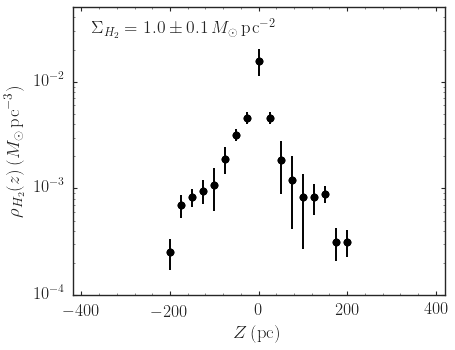

In [5]:
figsize(6,4.5)
bovy_plot.bovy_plot(1000.*zbinsp_h2,
                    counts_h2,'ko',semilogy=True,
                    lw=2.,zorder=2,
                    xlabel=r'$Z\,(\mathrm{pc})$',
                    ylabel=r'$\rho_{H_2}(z)\,(M_\odot\,\mathrm{pc}^{-3})$',
                    xrange=[-420,420],yrange=[0.1/1000.,50./1000.])
errorbar(1000.*zbinsp_h2,counts_h2,yerr=ecounts_h2,color='k',marker='o',
        ls='None')
bovy_plot.bovy_text(r'$\Sigma_{H_2} = %.1f \pm %.1f\,M_\odot\,\mathrm{pc}^{-2}$' \
                    % (numpy.nansum(counts_h2)*(zbinsp_h2[1]-zbinsp_h2[0])*1000.,
                       numpy.sqrt(numpy.nansum(ecounts_h2**2.))*(zbinsp_h2[1]-zbinsp_h2[0])*1000.),
                    top_left=True,size=16.)

The uncertainty in the surface density is 10%. There is an addition, larger uncertainty of about 30% due to the uncertainty CO-to-$H_2$ conversion, which we will apply separately (because it is a systematic).

#### HI

McKee et al. refer to [Dickey & Lockman (1990)](http://adsabs.harvard.edu/abs/1990ARA%26A..28..215D) for the vertical distribution of HI. This model has three components: two Gaussian components, with mid-plane normalizations of 0.395 and 0.107 and FWHMs of 212 pc and 530 pc; the third component is an exponential with mid-plane normalization 0.064 and a scale height of 403 pc.

McKee et al. also refer to [Kalberla & Dedes (2008)](http://adsabs.harvard.edu/abs/2008A%26A...487..951K) for an alternative model made up of two exponentials. The fit here actually seems to go back to [Kalberla & Kelp (1998)](http://adsabs.harvard.edu/abs/1998A%26A...339..745K).

We also consider a model based on the data from [Schmidt (1957)](http://adsabs.harvard.edu/abs/1957BAN....13..247S), taking their main Gaussian component and adding a small wider Gaussian to model the tails in their data.

We define functions for all three of these HI profiles and compare them to each other:

In [6]:
def dickeylockman(z):
    return (0.395*numpy.exp(-z**2.*4.*numpy.log(2.)/0.212**2.)\
            +0.107*numpy.exp(-z**2.*4.*numpy.log(2.)/0.530**2.)\
            +0.064*numpy.exp(-numpy.fabs(z)/0.403))/0.566
def kalberla(z):
    return (0.5*numpy.exp(-numpy.fabs(z)/0.15)+0.19*numpy.exp(-numpy.fabs(z)/0.5))/0.69
def schmidt(z):
    return (numpy.exp(-z**2.*4.*numpy.log(2.)/0.220**2.)\
            +0.2*numpy.exp(-z**2.*4.*numpy.log(2.)/0.520**2.))/1.2

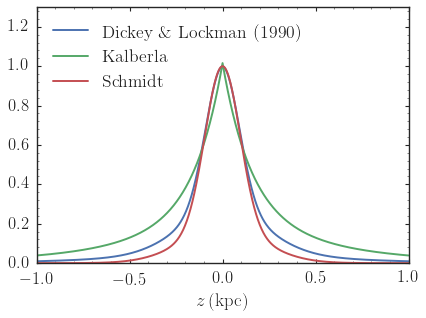

In [7]:
figsize(6,4)
xs= numpy.linspace(-1.,1.,1001)
bovy_plot.bovy_plot(xs,dickeylockman(xs),label=r'$\mathrm{Dickey\ \&\ Lockman\ (1990)}$',
                    xlabel=r'$z\,(\mathrm{kpc})$',
                    xrange=[-1.,1.],
                    yrange=[0.,1.3])
plot(xs,kalberla(xs)*0.69/0.566/1.2,label=r'$\mathrm{Kalberla}$')
plot(xs,schmidt(xs),label=r'$\mathrm{Schmidt}$')
legend(loc='upper left',fontsize=16.)

Now we will take the Dickey & Lockman model as the fiducial model and quantify the uncertainty as the spread between the three models. We further add an overall 10% uncertainty in the counts and an uncertainty that decreases quadratically with height up to 600 pc, because observations are most confused and difficult close to the mid-plane. There's quite a bit of data (e.g., Schmidt 1957), so we'll bin the data into our normal bins:

In [8]:
zbins_hi= numpy.arange(-0.8125,0.825,0.025)
zbinsp_hi= 0.5*(numpy.roll(zbins_hi,-1)+zbins_hi)[:-1]
counts_hi= dickeylockman(zbinsp_hi)
ecounts_hi= numpy.std([dickeylockman(zbinsp_hi),schmidt(zbinsp_hi),kalberla(zbinsp_hi)],axis=0)\
            +0.1*counts_hi+(0.6-numpy.fabs(zbinsp_hi))**2.*0.2
counts_hi+= numpy.random.normal(size=len(counts_hi))*ecounts_hi
# Normalize
norm_xs= numpy.linspace(0.,1.1,1001)
sfmass= numpy.sum(dickeylockman(norm_xs))*2.*(norm_xs[1]-norm_xs[0])*1000.
counts_hi/= sfmass/10.7
ecounts_hi/= sfmass/10.7

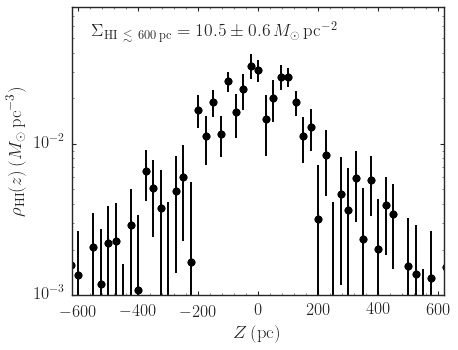

In [9]:
figsize(6,4.5)
bovy_plot.bovy_plot(1000.*zbinsp_hi,
                    counts_hi,'ko',semilogy=True,
                    lw=2.,zorder=2,
                    xlabel=r'$Z\,(\mathrm{pc})$',
                    ylabel=r'$\rho_{\mathrm{HI}}(z)\,(M_\odot\,\mathrm{pc}^{-3})$',
                    xrange=[-620,620],yrange=[1./1000.,80./1000.])
errorbar(1000.*zbinsp_hi,counts_hi,yerr=ecounts_hi,color='k',marker='o',
        ls='None')
bovy_plot.bovy_text(r'$\Sigma_{\mathrm{HI}\ \lesssim\ 600\,\mathrm{pc}} = %.1f \pm %.1f\,M_\odot\,\mathrm{pc}^{-2}$' \
                    % (numpy.nansum(counts_hi)*(zbinsp_hi[1]-zbinsp_hi[0])*1000.,
                       numpy.sqrt(numpy.nansum(ecounts_hi**2.))*(zbinsp_hi[1]-zbinsp_hi[0])*1000.),
                    top_left=True,size=16.)

This gives a not unreasonable looking uncertainty, although the uncertainty on the total surface density remains small. We will allow for an additional, systematic offset later.

#### HII

We follow McKee et al. and consider the models fit to pulsar dispersion measures discussed by [Schnitzeler (2012)](http://adsabs.harvard.edu/abs/2012MNRAS.427..664S). In particular, we consider their simple single-disk models: (a) the exponential disk of [Berkhuijsen & Müller](http://adsabs.harvard.edu/abs/2008A%26A...490..179B) with a scale height of 930 pc, (b) the exponential disk of [Gaensler et al. (2008)](http://adsabs.harvard.edu/abs/2008PASA...25..184G) which has a scale height of 1.83 kpc, and (c) the exponential disk fitted by Schnitzeler, which has a scale height of 1.59 kpc. These three models look like this:

In [10]:
def berkhuijsen(z):
    return 21.7/0.93*numpy.exp(-numpy.fabs(z)/0.93)/25.6
def gaensler(z):
    return 25.6/1.83*numpy.exp(-numpy.fabs(z)/1.83)/25.6
def schnitzeler(z):
    return 24.4/1.59*numpy.exp(-numpy.fabs(z)/1.59)/25.6

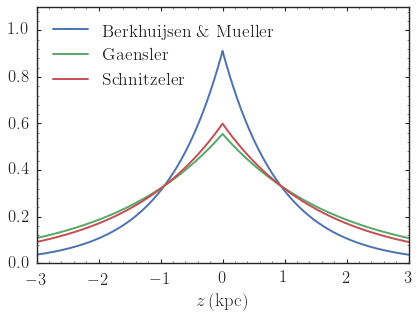

In [11]:
figsize(6,4)
xs= numpy.linspace(-3.,3.,1001)
bovy_plot.bovy_plot(xs,berkhuijsen(xs),
                    label=r'$\mathrm{Berkhuijsen\ \&\ Mueller}$',
                    xlabel=r'$z\,(\mathrm{kpc})$',
                    xrange=[-3.,3.],
                    yrange=[0.,1.1])
plot(xs,gaensler(xs)*0.69/0.566/1.2,label=r'$\mathrm{Gaensler}$')
plot(xs,schnitzeler(xs),label=r'$\mathrm{Schnitzeler}$')
legend(loc='upper left',fontsize=16.)

The Berkhuijsen & Muller model is quite different from the others, especially at low $z$. The data on pulsar dispersion measures appears to be quite sparse near the plane, so perhaps the range spanned by these three models does not seem too small and we will conservatively consider the spread as an estimate of the error. We bin the profile in 100 pc bins (based on the available data in Schnitzeler) and scale the uncertainties up somewhat further to create a total column density with a similar uncertainty as in McKee et al.

In [12]:
zbins_hii= numpy.arange(-2.05,2.15,0.1)
zbinsp_hii= 0.5*(numpy.roll(zbins_hii,-1)+zbins_hii)[:-1]
counts_hii= schnitzeler(zbinsp_hii)
ecounts_hii= numpy.std([schnitzeler(zbinsp_hii),gaensler(zbinsp_hii),berkhuijsen(zbinsp_hii)],axis=0)*1.5
ecounts_hii[numpy.fabs(zbinsp_hii) > 0.5]*= 2.5
counts_hii+= numpy.random.normal(size=len(counts_hii))*ecounts_hii
# Normalize
norm_xs= numpy.linspace(0.,5.1,1001)
sfmass= numpy.sum(schnitzeler(norm_xs))*2.*(norm_xs[1]-norm_xs[0])*1000.
counts_hii/= sfmass/1.8
ecounts_hii/= sfmass/1.8

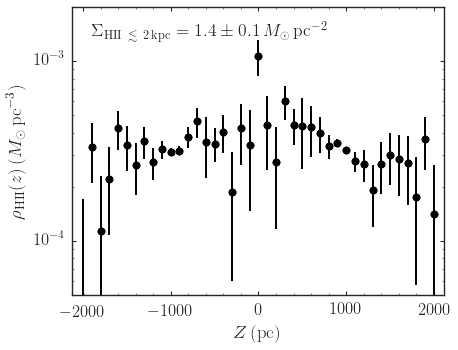

In [13]:
figsize(6,4.5)
bovy_plot.bovy_plot(1000.*zbinsp_hii,
                    counts_hii,'ko',semilogy=True,
                    lw=2.,zorder=2,
                    xlabel=r'$Z\,(\mathrm{pc})$',
                    ylabel=r'$\rho_{\mathrm{HII}}(z)\,(M_\odot\,\mathrm{pc}^{-3})$',
                    xrange=[-2120,2120],yrange=[0.05/1000.,2./1000.])
errorbar(1000.*zbinsp_hii,counts_hii,yerr=ecounts_hii,color='k',marker='o',
        ls='None')
bovy_plot.bovy_text(r'$\Sigma_{\mathrm{HII}\ \lesssim\ 2\,\mathrm{kpc}} = %.1f \pm %.1f\,M_\odot\,\mathrm{pc}^{-2}$' \
                    % (numpy.nansum(counts_hii)*(zbinsp_hii[1]-zbinsp_hii[0])*1000.,
                       numpy.sqrt(numpy.nansum(ecounts_hii**2.))*(zbinsp_hii[1]-zbinsp_hii[0])*1000.),
                    top_left=True,size=16.)

This profile correctly conveys that the overall profile is quite flat and leads to a reasonable uncertainty on the total column. 

#### Summary of gas data

The following plot summarizes the gas data:

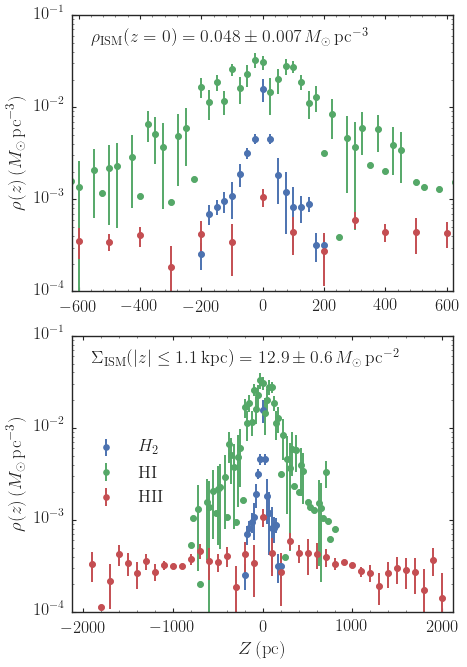

In [14]:
figsize(6,8.5)
marker='o'
ms= 6.
for ii,(xrange,yrange,xlabel) in enumerate(zip([[-620.,620.],[-2120,2120]],
                                               [[10.**-4.,10.**-1.],[10.**-4.,10.**-1.]],
                                                [None,r'$Z\,(\mathrm{pc})$'])):
    subplot(2,1,ii+1)
    # H2
    bovy_plot.bovy_plot(1000.*zbinsp_h2,
                        counts_h2,marker,semilogy=True,gcf=True,ms=ms,
                        lw=2.,zorder=2,color=sns.color_palette()[0],
                        xlabel=xlabel,
                        ylabel=r'$\rho(z)\,(M_\odot\,\mathrm{pc}^{-3})$',
                        xrange=xrange,yrange=yrange)
    errorbar(1000.*zbinsp_h2,counts_h2,yerr=ecounts_h2,marker=marker,color=sns.color_palette()[0],
            ls='None',ms=ms,label=r'$H_2$')
    #HI
    bovy_plot.bovy_plot(1000.*zbinsp_hi,
                        counts_hi,marker,semilogy=True,ms=ms,
                        color=sns.color_palette()[1],
                        lw=2.,zorder=2,overplot=True)
    errorbar(1000.*zbinsp_hi,counts_hi,yerr=ecounts_hi,marker=marker,color=sns.color_palette()[1],
            ls='None',ms=ms,label=r'$\mathrm{HI}$')
    #HII
    bovy_plot.bovy_plot(1000.*zbinsp_hii,
                        counts_hii,marker,semilogy=True,ms=ms,
                        color=sns.color_palette()[2],
                        lw=2.,zorder=2,overplot=True)
    errorbar(1000.*zbinsp_hii,counts_hii,yerr=ecounts_hii,marker=marker,color=sns.color_palette()[2],
            ls='None',ms=ms,label=r'$\mathrm{HII}$')
    if ii == 0:
        bovy_plot.bovy_text(r'$\rho_{\mathrm{ISM}}(z=0) = %.3f\pm%.3f\,M_\odot\,\mathrm{pc}^{-3}$' \
                           % (counts_h2[len(zbinsp_h2)//2]
                              +counts_hi[len(zbinsp_hi)//2]
                              +counts_hii[len(zbinsp_hii)//2]\
                              ,numpy.sqrt(ecounts_h2[len(zbinsp_h2)//2]**2.\
                               +ecounts_hi[len(zbinsp_hi)//2]**2.+
                                ecounts_hii[len(zbinsp_hii)//2]**2.)),
                           top_left=True,size=16.)
    elif ii == 1:
        bovy_plot.bovy_text(r'$\Sigma_{\mathrm{ISM}}(|z| \leq 1.1\,\mathrm{kpc}) = %.1f\pm%.1f\,M_\odot\,\mathrm{pc}^{-2}$' \
                           % (1000.*(numpy.nansum(counts_h2)*(zbins_h2[1]-zbins_h2[0])
                              +numpy.nansum(counts_hi)*(zbins_hi[1]-zbins_hi[0])
                              +numpy.nansum(counts_hii)*(zbins_hii[1]-zbins_hii[0])),
                              1000.*numpy.sqrt(numpy.nansum(ecounts_h2**2.)*(zbins_h2[1]-zbins_h2[0])**2.
                              +numpy.nansum(ecounts_hi**2.)*(zbins_hi[1]-zbins_hi[0])**2.
                              +numpy.nansum(ecounts_hii**2.)*(zbins_hii[1]-zbins_hii[0])**2.)),
                           top_left=True,size=16.)
legend(loc='center left',fontsize=16.)
tight_layout()

The total uncertainties are small because they do not include the systematic 30% uncertainty in the $H_2$ and the systematic 15% uncertainty in the HI.